# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

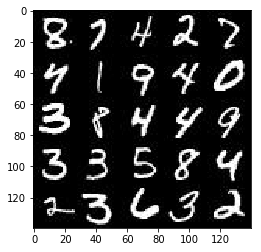

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

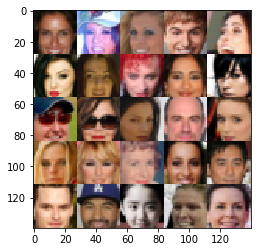

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_r = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_r")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, (None), name="learn_rate")

    return input_r, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [37]:
def conv2d(inputs, depth, kernel_size, strides, padding):
    return tf.layers.conv2d(
        inputs, depth, kernel_size, strides, padding,
        activation=None, 
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28x3
        conv_1 = conv2d(images, 64, 5, 2, "same")
        relu_1 = tf.maximum(alpha*conv_1, conv_1)

        #14x14x64
        conv_2 = conv2d(relu_1, 128, 5, 2, "same")
        norm_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = tf.maximum(alpha*norm_2, norm_2)

        #7x7x128
        conv_3 = conv2d(relu_2, 256, 5, 2, "same")
        norm_3 = tf.layers.batch_normalization(conv_3, training=True)
        relu_3 = tf.maximum(alpha*norm_3, norm_3)

        #4x4x256
        flat_4 = tf.reshape(relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat_4, 1, activation=None)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def conv2d_transpose(inputs, depth, kernel_size, strides, padding):
    return tf.layers.conv2d_transpose(
        inputs, depth, kernel_size, strides, padding, 
        activation=None, 
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope("generator", reuse=not is_train):
        full_1 = tf.layers.dense(z, 3*3*512, activation=None)
        conv_1 = tf.reshape(full_1, (-1, 3, 3, 512))
        norm_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        relu_1 = tf.maximum(alpha*norm_1, norm_1)
        drop_1 = tf.layers.dropout(relu_1, 0.5, training=is_train)
        
        #3x3x512
        conv_2 = conv2d_transpose(drop_1, 256, 5, 2, "same")
        norm_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        relu_2 = tf.maximum(alpha*norm_2, norm_2)
        drop_2 = tf.layers.dropout(relu_2, 0.5, training=is_train)
        
        #6x6x256
        conv_3 = conv2d_transpose(drop_2, 128, 5, 2, "same")
        norm_3 = tf.layers.batch_normalization(conv_3, training=is_train)
        relu_3 = tf.maximum(alpha*norm_3, norm_3)
        drop_3 = tf.layers.dropout(relu_3, 0.5, training=is_train)
        
        #12x12x128
        logits = conv2d_transpose(drop_3, out_channel_dim, 6, 2, "valid")
        
        #28x28x64
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    input_fake = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    _, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    _, d_logits_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith("discriminator")]
    g_vars = [v for v in t_vars if v.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [68]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    _, image_width, image_height, image_channels = data_shape
    input_r, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_r, input_z, image_channels)
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate=learn_rate, beta1=beta1)
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    d_train, feed_dict={input_r: batch_images*2, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(
                    g_train, feed_dict={input_r: batch_images*2, input_z: batch_z, learn_rate: learning_rate})
                
                if step % 10 == 0:
                    d_loss_train = d_loss.eval({input_r: batch_images*2, input_z: batch_z})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    print("Epoch: {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator loss: {:.4f}...".format(d_loss_train), 
                          "Generator loss: {:.4f}".format(g_loss_train))
                
                if step % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2... Discriminator loss: 0.5031... Generator loss: 3.9943
Epoch: 1/2... Discriminator loss: 2.4921... Generator loss: 0.1879
Epoch: 1/2... Discriminator loss: 0.8374... Generator loss: 1.3497
Epoch: 1/2... Discriminator loss: 0.6955... Generator loss: 1.7184
Epoch: 1/2... Discriminator loss: 0.5786... Generator loss: 2.0681
Epoch: 1/2... Discriminator loss: 0.5013... Generator loss: 3.3908
Epoch: 1/2... Discriminator loss: 0.4746... Generator loss: 3.6464
Epoch: 1/2... Discriminator loss: 0.4718... Generator loss: 2.9850
Epoch: 1/2... Discriminator loss: 0.4261... Generator loss: 3.2510
Epoch: 1/2... Discriminator loss: 0.5254... Generator loss: 2.0897


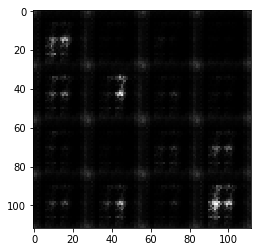

Epoch: 1/2... Discriminator loss: 0.5778... Generator loss: 2.8359
Epoch: 1/2... Discriminator loss: 0.4668... Generator loss: 2.8907
Epoch: 1/2... Discriminator loss: 0.5542... Generator loss: 2.1490
Epoch: 1/2... Discriminator loss: 0.4264... Generator loss: 3.5512
Epoch: 1/2... Discriminator loss: 0.4376... Generator loss: 2.9279
Epoch: 1/2... Discriminator loss: 2.0949... Generator loss: 0.3250
Epoch: 1/2... Discriminator loss: 0.6281... Generator loss: 2.2537
Epoch: 1/2... Discriminator loss: 0.4806... Generator loss: 3.4166
Epoch: 1/2... Discriminator loss: 0.4362... Generator loss: 3.4635
Epoch: 1/2... Discriminator loss: 0.5870... Generator loss: 1.9306


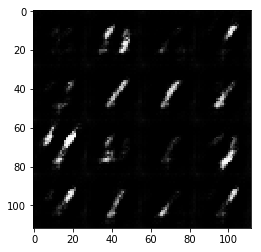

Epoch: 1/2... Discriminator loss: 0.4748... Generator loss: 3.4781
Epoch: 1/2... Discriminator loss: 0.4617... Generator loss: 2.7869
Epoch: 1/2... Discriminator loss: 0.5042... Generator loss: 2.4483
Epoch: 1/2... Discriminator loss: 0.6311... Generator loss: 2.1757
Epoch: 1/2... Discriminator loss: 0.6242... Generator loss: 1.8581
Epoch: 1/2... Discriminator loss: 0.5590... Generator loss: 2.1717
Epoch: 1/2... Discriminator loss: 0.5347... Generator loss: 2.9315
Epoch: 1/2... Discriminator loss: 0.7040... Generator loss: 1.9950
Epoch: 1/2... Discriminator loss: 0.5616... Generator loss: 2.1778
Epoch: 1/2... Discriminator loss: 0.5050... Generator loss: 2.6631


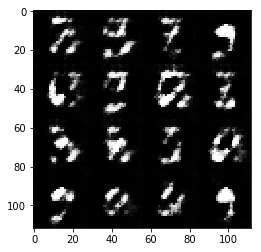

Epoch: 1/2... Discriminator loss: 0.6028... Generator loss: 2.1808
Epoch: 1/2... Discriminator loss: 0.6113... Generator loss: 2.0294
Epoch: 1/2... Discriminator loss: 0.5666... Generator loss: 2.0615
Epoch: 1/2... Discriminator loss: 0.6830... Generator loss: 2.9684
Epoch: 1/2... Discriminator loss: 0.6539... Generator loss: 2.1142
Epoch: 1/2... Discriminator loss: 0.6408... Generator loss: 2.5079
Epoch: 1/2... Discriminator loss: 0.7994... Generator loss: 2.5958
Epoch: 1/2... Discriminator loss: 0.5980... Generator loss: 2.5372
Epoch: 1/2... Discriminator loss: 0.6549... Generator loss: 2.1528
Epoch: 1/2... Discriminator loss: 0.6879... Generator loss: 1.8921


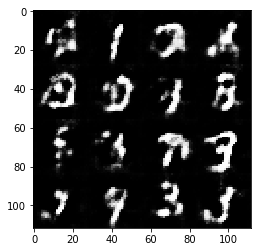

Epoch: 1/2... Discriminator loss: 0.7273... Generator loss: 1.6003
Epoch: 1/2... Discriminator loss: 0.6076... Generator loss: 2.2282
Epoch: 1/2... Discriminator loss: 0.5725... Generator loss: 2.7475
Epoch: 1/2... Discriminator loss: 0.7432... Generator loss: 3.0569
Epoch: 1/2... Discriminator loss: 0.5943... Generator loss: 2.2744
Epoch: 1/2... Discriminator loss: 0.5813... Generator loss: 2.6041
Epoch: 2/2... Discriminator loss: 0.6282... Generator loss: 1.8066
Epoch: 2/2... Discriminator loss: 0.6343... Generator loss: 2.6419
Epoch: 2/2... Discriminator loss: 0.6653... Generator loss: 3.2707
Epoch: 2/2... Discriminator loss: 0.6646... Generator loss: 1.5977


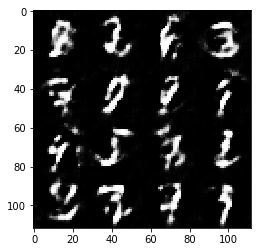

Epoch: 2/2... Discriminator loss: 0.8383... Generator loss: 3.4896
Epoch: 2/2... Discriminator loss: 0.5774... Generator loss: 2.5610
Epoch: 2/2... Discriminator loss: 0.7055... Generator loss: 1.4420
Epoch: 2/2... Discriminator loss: 0.8698... Generator loss: 3.2791
Epoch: 2/2... Discriminator loss: 0.6169... Generator loss: 1.7632
Epoch: 2/2... Discriminator loss: 0.6234... Generator loss: 1.7349
Epoch: 2/2... Discriminator loss: 0.7753... Generator loss: 1.3088
Epoch: 2/2... Discriminator loss: 0.7330... Generator loss: 1.3557
Epoch: 2/2... Discriminator loss: 1.1163... Generator loss: 4.3103
Epoch: 2/2... Discriminator loss: 0.6170... Generator loss: 2.2652


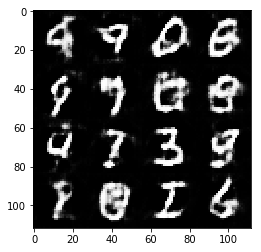

Epoch: 2/2... Discriminator loss: 0.5698... Generator loss: 2.1796
Epoch: 2/2... Discriminator loss: 0.8240... Generator loss: 1.0936
Epoch: 2/2... Discriminator loss: 0.5839... Generator loss: 2.0712
Epoch: 2/2... Discriminator loss: 0.5706... Generator loss: 1.7626
Epoch: 2/2... Discriminator loss: 0.5752... Generator loss: 1.9892
Epoch: 2/2... Discriminator loss: 0.5982... Generator loss: 1.7485
Epoch: 2/2... Discriminator loss: 0.5688... Generator loss: 2.3377
Epoch: 2/2... Discriminator loss: 0.6739... Generator loss: 3.1020
Epoch: 2/2... Discriminator loss: 0.6036... Generator loss: 1.6827
Epoch: 2/2... Discriminator loss: 0.7145... Generator loss: 1.4847


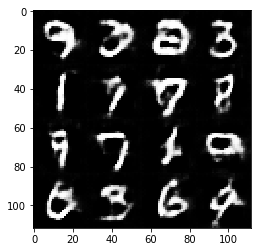

Epoch: 2/2... Discriminator loss: 0.5674... Generator loss: 2.4894
Epoch: 2/2... Discriminator loss: 0.7142... Generator loss: 1.3359
Epoch: 2/2... Discriminator loss: 0.6086... Generator loss: 1.8624
Epoch: 2/2... Discriminator loss: 0.6000... Generator loss: 2.1162
Epoch: 2/2... Discriminator loss: 0.9124... Generator loss: 1.0266
Epoch: 2/2... Discriminator loss: 0.5499... Generator loss: 2.0849
Epoch: 2/2... Discriminator loss: 0.7256... Generator loss: 3.1643
Epoch: 2/2... Discriminator loss: 0.5379... Generator loss: 2.5918
Epoch: 2/2... Discriminator loss: 0.6054... Generator loss: 1.7355
Epoch: 2/2... Discriminator loss: 0.5962... Generator loss: 2.5241


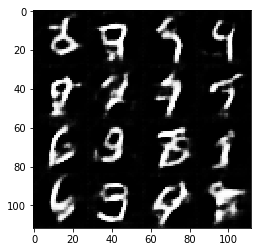

Epoch: 2/2... Discriminator loss: 0.5919... Generator loss: 2.0124
Epoch: 2/2... Discriminator loss: 0.5727... Generator loss: 2.6895
Epoch: 2/2... Discriminator loss: 0.5753... Generator loss: 1.9681
Epoch: 2/2... Discriminator loss: 0.5406... Generator loss: 2.3578
Epoch: 2/2... Discriminator loss: 1.1125... Generator loss: 0.9214
Epoch: 2/2... Discriminator loss: 0.5649... Generator loss: 1.8982
Epoch: 2/2... Discriminator loss: 0.5201... Generator loss: 2.3057
Epoch: 2/2... Discriminator loss: 0.5646... Generator loss: 2.2539
Epoch: 2/2... Discriminator loss: 0.5814... Generator loss: 2.5706
Epoch: 2/2... Discriminator loss: 0.6000... Generator loss: 1.7935


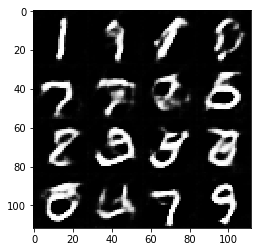

Epoch: 2/2... Discriminator loss: 0.5477... Generator loss: 2.6237
Epoch: 2/2... Discriminator loss: 0.5563... Generator loss: 1.9191
Epoch: 2/2... Discriminator loss: 0.5841... Generator loss: 1.9994


In [69]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1... Discriminator loss: 0.4895... Generator loss: 2.9354
Epoch: 1/1... Discriminator loss: 0.4225... Generator loss: 3.7085
Epoch: 1/1... Discriminator loss: 0.4039... Generator loss: 3.5368
Epoch: 1/1... Discriminator loss: 0.4079... Generator loss: 6.3951
Epoch: 1/1... Discriminator loss: 0.4874... Generator loss: 3.7035
Epoch: 1/1... Discriminator loss: 0.4621... Generator loss: 3.9832
Epoch: 1/1... Discriminator loss: 1.6185... Generator loss: 0.4592
Epoch: 1/1... Discriminator loss: 0.6116... Generator loss: 1.9068
Epoch: 1/1... Discriminator loss: 0.6783... Generator loss: 1.8118
Epoch: 1/1... Discriminator loss: 0.5536... Generator loss: 2.1006


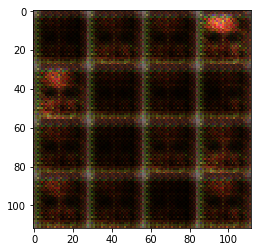

Epoch: 1/1... Discriminator loss: 0.4319... Generator loss: 3.6320
Epoch: 1/1... Discriminator loss: 0.3950... Generator loss: 4.0506
Epoch: 1/1... Discriminator loss: 0.4572... Generator loss: 2.7590
Epoch: 1/1... Discriminator loss: 0.5966... Generator loss: 1.9953
Epoch: 1/1... Discriminator loss: 0.3931... Generator loss: 4.1734
Epoch: 1/1... Discriminator loss: 0.3939... Generator loss: 4.1975
Epoch: 1/1... Discriminator loss: 0.4271... Generator loss: 6.6559
Epoch: 1/1... Discriminator loss: 0.4197... Generator loss: 4.2900
Epoch: 1/1... Discriminator loss: 0.3889... Generator loss: 3.9991
Epoch: 1/1... Discriminator loss: 0.4323... Generator loss: 2.8871


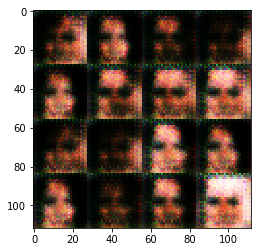

Epoch: 1/1... Discriminator loss: 0.3803... Generator loss: 4.2076
Epoch: 1/1... Discriminator loss: 0.4056... Generator loss: 5.1262
Epoch: 1/1... Discriminator loss: 0.4013... Generator loss: 3.9194
Epoch: 1/1... Discriminator loss: 0.4451... Generator loss: 2.9589
Epoch: 1/1... Discriminator loss: 0.5246... Generator loss: 2.2287
Epoch: 1/1... Discriminator loss: 0.3974... Generator loss: 3.6579
Epoch: 1/1... Discriminator loss: 0.4041... Generator loss: 3.2888
Epoch: 1/1... Discriminator loss: 0.3894... Generator loss: 3.8498
Epoch: 1/1... Discriminator loss: 0.4007... Generator loss: 3.3476
Epoch: 1/1... Discriminator loss: 0.4057... Generator loss: 3.3032


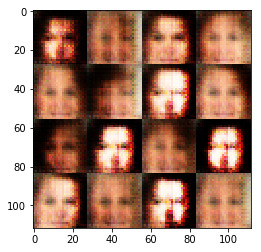

Epoch: 1/1... Discriminator loss: 0.4123... Generator loss: 4.4319
Epoch: 1/1... Discriminator loss: 0.5896... Generator loss: 3.3485
Epoch: 1/1... Discriminator loss: 0.3822... Generator loss: 4.2923
Epoch: 1/1... Discriminator loss: 0.7890... Generator loss: 6.7508
Epoch: 1/1... Discriminator loss: 0.4455... Generator loss: 4.8516
Epoch: 1/1... Discriminator loss: 0.4413... Generator loss: 4.9442
Epoch: 1/1... Discriminator loss: 0.4133... Generator loss: 3.7922
Epoch: 1/1... Discriminator loss: 0.4051... Generator loss: 3.3647
Epoch: 1/1... Discriminator loss: 0.8148... Generator loss: 6.8123
Epoch: 1/1... Discriminator loss: 1.1434... Generator loss: 0.8735


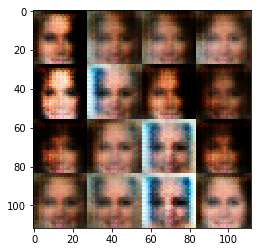

Epoch: 1/1... Discriminator loss: 0.7172... Generator loss: 1.5501
Epoch: 1/1... Discriminator loss: 0.4387... Generator loss: 3.2827
Epoch: 1/1... Discriminator loss: 0.9475... Generator loss: 5.3606
Epoch: 1/1... Discriminator loss: 0.4449... Generator loss: 3.4805
Epoch: 1/1... Discriminator loss: 0.4432... Generator loss: 2.8293
Epoch: 1/1... Discriminator loss: 0.4563... Generator loss: 3.7521
Epoch: 1/1... Discriminator loss: 0.4175... Generator loss: 4.3095
Epoch: 1/1... Discriminator loss: 0.4540... Generator loss: 3.5324
Epoch: 1/1... Discriminator loss: 0.5334... Generator loss: 4.7680
Epoch: 1/1... Discriminator loss: 1.1010... Generator loss: 1.0915


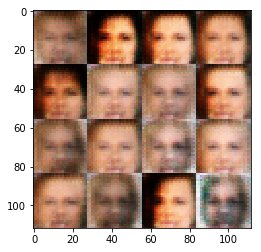

Epoch: 1/1... Discriminator loss: 0.5034... Generator loss: 2.5635
Epoch: 1/1... Discriminator loss: 0.4706... Generator loss: 3.4823
Epoch: 1/1... Discriminator loss: 0.5357... Generator loss: 2.5707
Epoch: 1/1... Discriminator loss: 0.5192... Generator loss: 2.5201
Epoch: 1/1... Discriminator loss: 0.5152... Generator loss: 3.5075
Epoch: 1/1... Discriminator loss: 0.5638... Generator loss: 3.9102
Epoch: 1/1... Discriminator loss: 0.6131... Generator loss: 1.9153
Epoch: 1/1... Discriminator loss: 0.5976... Generator loss: 2.0694
Epoch: 1/1... Discriminator loss: 0.6037... Generator loss: 1.7789
Epoch: 1/1... Discriminator loss: 0.4585... Generator loss: 3.1671


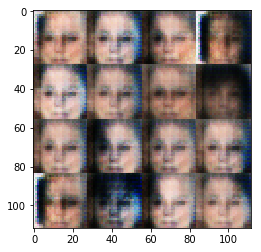

Epoch: 1/1... Discriminator loss: 0.5566... Generator loss: 2.2333
Epoch: 1/1... Discriminator loss: 0.9848... Generator loss: 1.0444
Epoch: 1/1... Discriminator loss: 0.5328... Generator loss: 2.9494
Epoch: 1/1... Discriminator loss: 0.6563... Generator loss: 2.4986
Epoch: 1/1... Discriminator loss: 0.6766... Generator loss: 1.6518
Epoch: 1/1... Discriminator loss: 0.5259... Generator loss: 2.3370
Epoch: 1/1... Discriminator loss: 0.5953... Generator loss: 2.2330
Epoch: 1/1... Discriminator loss: 0.5971... Generator loss: 2.5706
Epoch: 1/1... Discriminator loss: 0.6220... Generator loss: 2.0128
Epoch: 1/1... Discriminator loss: 0.5205... Generator loss: 2.6517


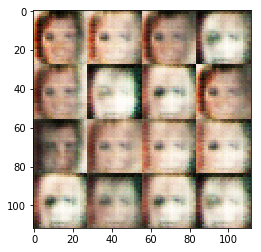

Epoch: 1/1... Discriminator loss: 0.5330... Generator loss: 2.5630
Epoch: 1/1... Discriminator loss: 0.5529... Generator loss: 3.5805
Epoch: 1/1... Discriminator loss: 0.4847... Generator loss: 3.1855
Epoch: 1/1... Discriminator loss: 0.5550... Generator loss: 2.3295
Epoch: 1/1... Discriminator loss: 0.6132... Generator loss: 2.0000
Epoch: 1/1... Discriminator loss: 0.5318... Generator loss: 2.7986
Epoch: 1/1... Discriminator loss: 0.5487... Generator loss: 2.3632
Epoch: 1/1... Discriminator loss: 0.5393... Generator loss: 2.3357
Epoch: 1/1... Discriminator loss: 0.4488... Generator loss: 3.6041
Epoch: 1/1... Discriminator loss: 0.4589... Generator loss: 3.5314


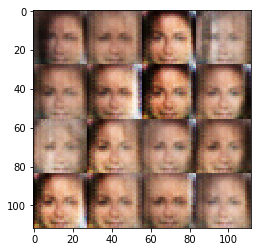

Epoch: 1/1... Discriminator loss: 0.4523... Generator loss: 4.2705
Epoch: 1/1... Discriminator loss: 0.6989... Generator loss: 1.6890
Epoch: 1/1... Discriminator loss: 0.4852... Generator loss: 3.2843
Epoch: 1/1... Discriminator loss: 0.5069... Generator loss: 3.0194
Epoch: 1/1... Discriminator loss: 0.4455... Generator loss: 3.1930
Epoch: 1/1... Discriminator loss: 0.4817... Generator loss: 3.1301
Epoch: 1/1... Discriminator loss: 0.4938... Generator loss: 3.9523
Epoch: 1/1... Discriminator loss: 0.5486... Generator loss: 2.5993
Epoch: 1/1... Discriminator loss: 0.4591... Generator loss: 3.1061
Epoch: 1/1... Discriminator loss: 0.5024... Generator loss: 2.5375


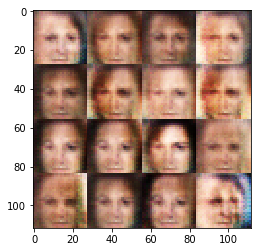

Epoch: 1/1... Discriminator loss: 0.4727... Generator loss: 2.7335
Epoch: 1/1... Discriminator loss: 0.4571... Generator loss: 3.0239
Epoch: 1/1... Discriminator loss: 0.8828... Generator loss: 1.5287
Epoch: 1/1... Discriminator loss: 1.6191... Generator loss: 6.9256
Epoch: 1/1... Discriminator loss: 0.5898... Generator loss: 2.0479
Epoch: 1/1... Discriminator loss: 0.5841... Generator loss: 4.0973
Epoch: 1/1... Discriminator loss: 0.5502... Generator loss: 6.1003
Epoch: 1/1... Discriminator loss: 0.4506... Generator loss: 3.3641
Epoch: 1/1... Discriminator loss: 0.9232... Generator loss: 4.8936
Epoch: 1/1... Discriminator loss: 0.5828... Generator loss: 1.7944


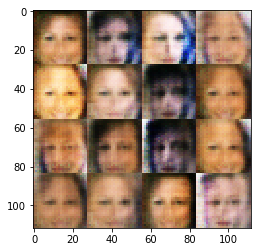

Epoch: 1/1... Discriminator loss: 0.5430... Generator loss: 2.5591
Epoch: 1/1... Discriminator loss: 0.5762... Generator loss: 3.2237
Epoch: 1/1... Discriminator loss: 0.7274... Generator loss: 4.3148
Epoch: 1/1... Discriminator loss: 0.4620... Generator loss: 3.5915
Epoch: 1/1... Discriminator loss: 0.4860... Generator loss: 3.0335
Epoch: 1/1... Discriminator loss: 0.5816... Generator loss: 1.8886
Epoch: 1/1... Discriminator loss: 0.5614... Generator loss: 2.1715
Epoch: 1/1... Discriminator loss: 0.5614... Generator loss: 3.0964
Epoch: 1/1... Discriminator loss: 0.8260... Generator loss: 1.1932
Epoch: 1/1... Discriminator loss: 0.6872... Generator loss: 1.5449


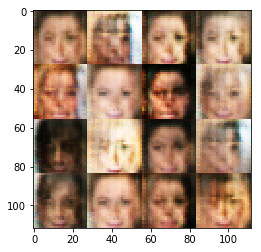

Epoch: 1/1... Discriminator loss: 0.5225... Generator loss: 2.6927
Epoch: 1/1... Discriminator loss: 0.8473... Generator loss: 5.1741
Epoch: 1/1... Discriminator loss: 0.5233... Generator loss: 2.9687
Epoch: 1/1... Discriminator loss: 0.4888... Generator loss: 2.9438
Epoch: 1/1... Discriminator loss: 0.9440... Generator loss: 5.3512
Epoch: 1/1... Discriminator loss: 0.5044... Generator loss: 2.8761
Epoch: 1/1... Discriminator loss: 0.6346... Generator loss: 3.1040
Epoch: 1/1... Discriminator loss: 0.6015... Generator loss: 2.7963
Epoch: 1/1... Discriminator loss: 0.4906... Generator loss: 2.8025
Epoch: 1/1... Discriminator loss: 0.5225... Generator loss: 3.1634


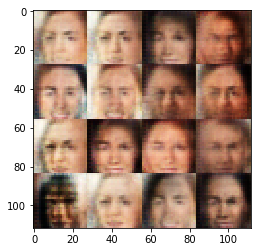

Epoch: 1/1... Discriminator loss: 0.6360... Generator loss: 1.6524
Epoch: 1/1... Discriminator loss: 0.5307... Generator loss: 2.4963
Epoch: 1/1... Discriminator loss: 0.6484... Generator loss: 2.3688
Epoch: 1/1... Discriminator loss: 0.5147... Generator loss: 2.6942
Epoch: 1/1... Discriminator loss: 0.5184... Generator loss: 3.7768
Epoch: 1/1... Discriminator loss: 0.5183... Generator loss: 2.9738
Epoch: 1/1... Discriminator loss: 0.8613... Generator loss: 1.3618
Epoch: 1/1... Discriminator loss: 0.5717... Generator loss: 2.0463
Epoch: 1/1... Discriminator loss: 0.5473... Generator loss: 3.9264
Epoch: 1/1... Discriminator loss: 0.6496... Generator loss: 1.8093


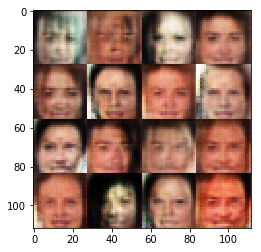

Epoch: 1/1... Discriminator loss: 0.5139... Generator loss: 2.4413
Epoch: 1/1... Discriminator loss: 0.5753... Generator loss: 2.0555
Epoch: 1/1... Discriminator loss: 0.5912... Generator loss: 2.0590
Epoch: 1/1... Discriminator loss: 0.6328... Generator loss: 1.7224
Epoch: 1/1... Discriminator loss: 0.7365... Generator loss: 1.5485
Epoch: 1/1... Discriminator loss: 0.6097... Generator loss: 2.1379
Epoch: 1/1... Discriminator loss: 0.4752... Generator loss: 3.1270
Epoch: 1/1... Discriminator loss: 0.5630... Generator loss: 2.0294
Epoch: 1/1... Discriminator loss: 0.5419... Generator loss: 2.3257
Epoch: 1/1... Discriminator loss: 0.6340... Generator loss: 2.0115


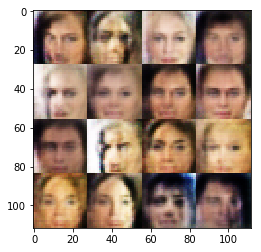

Epoch: 1/1... Discriminator loss: 0.7508... Generator loss: 3.3432
Epoch: 1/1... Discriminator loss: 0.5719... Generator loss: 2.1571
Epoch: 1/1... Discriminator loss: 0.6130... Generator loss: 3.8746
Epoch: 1/1... Discriminator loss: 0.5688... Generator loss: 2.0957
Epoch: 1/1... Discriminator loss: 0.6497... Generator loss: 1.7432
Epoch: 1/1... Discriminator loss: 0.6525... Generator loss: 1.6859
Epoch: 1/1... Discriminator loss: 0.5686... Generator loss: 2.0597
Epoch: 1/1... Discriminator loss: 0.6207... Generator loss: 1.9321
Epoch: 1/1... Discriminator loss: 0.5105... Generator loss: 2.4140
Epoch: 1/1... Discriminator loss: 0.5096... Generator loss: 2.4624


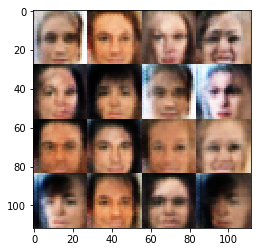

Epoch: 1/1... Discriminator loss: 0.7899... Generator loss: 4.3365
Epoch: 1/1... Discriminator loss: 0.5696... Generator loss: 2.1342
Epoch: 1/1... Discriminator loss: 0.6989... Generator loss: 1.6678
Epoch: 1/1... Discriminator loss: 0.8231... Generator loss: 1.1670
Epoch: 1/1... Discriminator loss: 0.5211... Generator loss: 2.6544
Epoch: 1/1... Discriminator loss: 0.5037... Generator loss: 2.9175
Epoch: 1/1... Discriminator loss: 0.7873... Generator loss: 1.5956
Epoch: 1/1... Discriminator loss: 0.5040... Generator loss: 2.5976


In [70]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.